In [1]:
!nvidia-smi

Tue Feb 23 06:32:11 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd 'drive/My Drive/Colab Notebooks/text_japanese/notebook/'
!ls

/content/drive/My Drive/Colab Notebooks/text_japanese/notebook
mecab-ipadic-neologd  ML_w2v.ipynb    word_count.ipynb
ML_BoW_tfi-df.ipynb   Untitled.ipynb  word_count_ngrams.ipynb


In [4]:
# https://qiita.com/jun40vn/items/78e33e29dce3d50c2df1

# 形態素分析ライブラリーMeCab と 辞書(mecab-ipadic-NEologd)のインストール 
!apt-get -q -y install sudo file mecab libmecab-dev mecab-ipadic-utf8 git curl python-mecab > /dev/null
!git clone --depth 1 https://github.com/neologd/mecab-ipadic-neologd.git > /dev/null 
!echo yes | mecab-ipadic-neologd/bin/install-mecab-ipadic-neologd -n > /dev/null 2>&1
!pip install mecab-python3 > /dev/null

# シンボリックリンクによるエラー回避
!ln -s /etc/mecabrc /usr/local/etc/mecabrc

fatal: destination path 'mecab-ipadic-neologd' already exists and is not an empty directory.
ln: failed to create symbolic link '/usr/local/etc/mecabrc': File exists


In [5]:
import os
from copy import deepcopy
from glob import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from wordcloud import WordCloud

import MeCab

In [7]:
df = pd.read_csv('../input/amazon_reviews_multilingual_JP_v1_00.tsv', sep='\t')
print(df.shape)
df.head()

(262256, 15)


,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,JP,65317,R33RSUD4ZTRKT7,B000001GBJ,957145596,SONGS FROM A SECRET GARDE,Music,1,1,15,N,Y,残念ながら…,残念ながら…趣味ではありませんでした。ケルト音楽の範疇にも幅があるのですね…,2012-12-05
1,JP,65317,R2U1VB8GPZBBEH,B000YPWBQ2,904244932,鏡の中の鏡‾ペルト作品集(SACD)(Arvo Part:Spiegel im Spiegel),Music,1,4,20,N,Y,残念ながら…,残念ながら…趣味ではありませんでした。正直退屈…眠気も起きない…,2012-12-05
2,JP,65696,R1IBRCJPPGWVJW,B0002E5O9G,108978277,Les Miserables 10th Anniversary Concert,Music,5,2,3,N,Y,ドリームキャスト,素晴らしいパフォーマンス。ミュージカル映画版の物足りない歌唱とは違います。,2013-03-02
3,JP,67162,RL02CW5XLYONU,B00004SRJ5,606528497,It Takes a Nation of Millions to Hold Us Back,Music,5,6,9,N,Y,やっぱりマスト,専門的な事を言わずにお勧めレコメを書きたいのですが、文才が無いので無理でした。ヒップホップが...,2013-08-11
4,JP,67701,R2LA2SS3HU3A3L,B0093H8H8I,509738390,Intel CPU Core I3-3225 3.3GHz 3MBキャッシュ LGA1155...,PC,4,2,4,N,Y,コスパ的には十分,今までの環境（Core2 Duo E4600)に比べれば十分に快適になりました。<br />...,2013-02-10


# tokenizer作成
- 品詞を限定して、分かち書きした、単語のリストを返す

In [8]:
path = "-d /usr/lib/x86_64-linux-gnu/mecab/dic/mecab-ipadic-neologd"
tagger = MeCab.Tagger(f"-Ochasen {path}")
def tokenize(text, target=['名詞', '動詞']):
        # 連結リスト
        node = tagger.parseToNode(text)

        result = []
        while node:
            hinshi = node.feature.split(",")[0]
            if hinshi in target:
                result.append(node.feature.split(",")[6])
            node = node.next

        return result

In [9]:
# 確認
text = '私は今日パンを食べました。'
print(tagger.parse(text))

私	ワタシ	私	名詞-代名詞-一般		
は	ハ	は	助詞-係助詞		
今日	キョウ	今日	名詞-副詞可能		
パン	パン	パン	名詞-一般		
を	ヲ	を	助詞-格助詞-一般		
食べ	タベ	食べる	動詞-自立	一段	連用形
まし	マシ	ます	助動詞	特殊・マス	連用形
た	タ	た	助動詞	特殊・タ	基本形
。	。	。	記号-句点		
EOS



In [10]:
tokenize(text)

['私', '今日', 'パン', '食べる']

## 前処理

In [11]:
from bs4 import BeautifulSoup

def clean_html(text, strip=True):
    soup = BeautifulSoup(text, 'html.parser')
    text = soup.get_text(strip=strip)
    return text

In [12]:
import re
def nornalize_number(text):
    text = re.sub(r'\d+', '0', text)
    return text

In [13]:
with open('../input/stopwords_slothlib.txt', 'r') as f:
    stopwords = [w.strip() for w in f]
    stopwords = set(stopwords)

add_stopwords = {
    '*',
    'あ','い','う','え','お',
    'か','き','く','け','こ',
    'さ','し','す','せ','そ',
    'た','ち','つ','て','と',
    'な','に','ぬ','ね','の',
    'は','ひ','ふ','へ','ほ',
    'ま','み','む','め','も',
    'や','ゆ','よ',
    'わ' ,'を','ん'
}
stopwords = stopwords | add_stopwords

def remove_stopwords(words):
    words = [w for w in words if w not in stopwords]
    return words

## ML
- 評価値を予測するモデルを作成
- ただし、5段階あって、３は判断が難しいので、今回は除き、
    - {1, 2} -> 0, {4, 5}->1とする2値分類モデルを作成する

## 1. データ準備

In [14]:
df.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,JP,65317,R33RSUD4ZTRKT7,B000001GBJ,957145596,SONGS FROM A SECRET GARDE,Music,1,1,15,N,Y,残念ながら…,残念ながら…趣味ではありませんでした。ケルト音楽の範疇にも幅があるのですね…,2012-12-05
1,JP,65317,R2U1VB8GPZBBEH,B000YPWBQ2,904244932,鏡の中の鏡‾ペルト作品集(SACD)(Arvo Part:Spiegel im Spiegel),Music,1,4,20,N,Y,残念ながら…,残念ながら…趣味ではありませんでした。正直退屈…眠気も起きない…,2012-12-05
2,JP,65696,R1IBRCJPPGWVJW,B0002E5O9G,108978277,Les Miserables 10th Anniversary Concert,Music,5,2,3,N,Y,ドリームキャスト,素晴らしいパフォーマンス。ミュージカル映画版の物足りない歌唱とは違います。,2013-03-02
3,JP,67162,RL02CW5XLYONU,B00004SRJ5,606528497,It Takes a Nation of Millions to Hold Us Back,Music,5,6,9,N,Y,やっぱりマスト,専門的な事を言わずにお勧めレコメを書きたいのですが、文才が無いので無理でした。ヒップホップが...,2013-08-11
4,JP,67701,R2LA2SS3HU3A3L,B0093H8H8I,509738390,Intel CPU Core I3-3225 3.3GHz 3MBキャッシュ LGA1155...,PC,4,2,4,N,Y,コスパ的には十分,今までの環境（Core2 Duo E4600)に比べれば十分に快適になりました。<br />...,2013-02-10


In [15]:
# 3を除く
df = df[df['star_rating']!=3]

# 2値にマッピング
star_rating_mapping = {1:0, 2:0, 4:1, 5:1}
df['star_rating'] = df['star_rating'].replace(star_rating_mapping)

In [16]:
# 確認
df['star_rating'] .value_counts(dropna=False)

1    208327
0     25901
Name: star_rating, dtype: int64

In [17]:
import string

def filter_by_ascii_rate(text, threshold=0.9):
    """テキスト中のアルファベットの割合が閾値以上のものをフィルター"""
    ascii_letters = set(string.printable)
    rate = sum(c in ascii_letters for c in text) / len(text)
    return rate<threshold

In [18]:
# 日本語レビューだけ抽出
df = df[df['review_body'].apply(filter_by_ascii_rate)]
print(df.shape)

(228826, 15)


In [19]:
X = df['review_body']
y = df['star_rating']

## 2. Tokenization

In [20]:
%%time
# 前処理+tokenization
X = [tokenize(nornalize_number(clean_html(text)), target=['名詞']) for text in X]

# stopwordsの除去
X_rm_stopwords = []
for tokens in X:
    X_rm_stopwords.append([w for w in tokens if w not in stopwords])

# スペース区切りの分かち書きの状態にする
# 多くのMLモデルは、英字をベースにしたもので、入力はスペース区切りを求められるので
X = [' '.join(tokens) for tokens in X_rm_stopwords]

CPU times: user 2min 2s, sys: 2.4 s, total: 2min 4s
Wall time: 2min 9s


In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 3. wordのインデックス化
- 便利なので、kerasのTokenizerクラスを用いる

In [22]:
from keras_preprocessing.text import Tokenizer

# 英字のスペース区切りのtokenに分割するもの、wordのindex化も出来る
# defaultで、いくつかの文字がfilterされることになっているので注意
tokenizer = Tokenizer(oov_token='<UNK>')  # index化する際に、trainに含まれていない単語を置き換える文字を指定
tokenizer.fit_on_texts(X_train)

vocab = tokenizer.word_index
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [23]:
X_train[0]

[7629, 2, 283, 7629]

In [24]:
# 確認
text1 = ['私 昨日 りんご 食べる']
text2 = ['私 昨日 みかん 食べる']
tokenizer_test = Tokenizer(oov_token='<UNK>')
tokenizer_test.fit_on_texts(text1)
print(tokenizer_test.word_index)  # word_indexの辞書
print(tokenizer_test.index_word)  # index_wordの辞書

print(tokenizer_test.texts_to_sequences(text1))
print(tokenizer_test.texts_to_sequences(text2))

{'<UNK>': 1, '私': 2, '昨日': 3, 'りんご': 4, '食べる': 5}
{1: '<UNK>', 2: '私', 3: '昨日', 4: 'りんご', 5: '食べる'}
[[2, 3, 4, 5]]
[[2, 3, 1, 5]]


## 4. padding
- 入力系列長を揃える
- これも便利なので、kerasを用いる

In [25]:
length_seq = [len(x) for x in X_train]
print('max:', np.max(length_seq))
print('min:', np.max(length_seq))
print('mean:', np.mean(length_seq))
print('median:', np.median(length_seq))
print('95%tile::', np.percentile(length_seq, 95))

max: 2901
min: 2901
mean: 33.34406205615645
median: 22.0
95%tile:: 99.0


In [26]:
from keras_preprocessing.sequence import pad_sequences

MAX_LEN = 100
X_train = pad_sequences(X_train, maxlen=MAX_LEN, padding='post', truncating='post', value=0)
X_test = pad_sequences(X_test, maxlen=MAX_LEN, padding='post', truncating='post', value=0)

# 上記でkerasでindex化したが、index=0は空いていて、それを<PAD>とする
vocab['<PAD>'] = 0

## 5. word embedding
- index化した各wordに対して、ベクトル表現を割り当てる
- 東北大が学習した、200次元word2vec

In [27]:
import gensim
model_dir = '../input/word2vec/entity_vector.model.bin'
model = gensim.models.KeyedVectors.load_word2vec_format(model_dir, binary=True)  # 元のファイルがbinゆえ、binary=True

In [28]:
# 確認, [word]として括弧で囲んで使うこと
model.most_similar('[理]')

[('[道_(哲学)]', 0.8235698938369751),
 ('[阿頼耶識]', 0.7655605673789978),
 ('[仁]', 0.7653003931045532),
 ('識', 0.7435705661773682),
 ('[義]', 0.7394132614135742),
 ('[仏性]', 0.7296761274337769),
 ('[気]', 0.7294569611549377),
 ('[法_(仏教)]', 0.7293650507926941),
 ('[真如]', 0.7274267673492432),
 ('[唯識]', 0.7263726592063904)]

In [29]:
def filter_embeddings(emb_model, vocab, dim, num_words=None):
    """
    vocabに存在する単語だけをフィルタリングして、word x ベクトル次元の行列を返す
    input:
        emb_model: {word1: vector1, word2: vector2, ...}というwordとベクトルの辞書的なもの
        vocab: {word1: 1, word2:　2, ...}というwordとindexの辞書的なもの
        dim: ベクトル次元
    
    * <UNK>, <PAD>は今、すべて0に割り当てられている
    """
    if not num_words:
        num_words = len(vocab)
    
    _embeddings = np.zeros((num_words, dim))
    for word in vocab:
        if word in emb_model:
            word_id = vocab[word]
            if word_id >= num_words:
                continue
            _embeddings[word_id] = emb_model[word]
    return _embeddings

In [30]:
embeddings = filter_embeddings(model, vocab, dim=200, num_words=None)

In [31]:
embeddings.shape

(105160, 200)

## 6. Model_2
- NN
- datasetクラス作成
- modelクラス作成
- trainループ作成

In [35]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset

In [36]:
import random

def seed_everything(seed: int):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(1234)

In [37]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
#device = 'cpu'
print(device)

cuda


In [38]:
class NNDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        text = self.X[idx]
        label = self.y[idx]
        return text, label

In [39]:
X_train_tt = torch.tensor(X_train, dtype=torch.long).to(device)  # indexはlong型に
X_test_tt = torch.tensor(X_test, dtype=torch.long).to(device)
y_train_tt = torch.tensor(y_train.values, dtype=torch.float).to(device)  # BCELossを使うために、float型に
y_test_tt = torch.tensor(y_test.values, dtype=torch.float).to(device)

In [40]:
train_dataset = NNDataset(X_train_tt, y_train_tt)
test_dataset = NNDataset(X_test_tt, y_test_tt)

In [41]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, drop_last=False)

In [42]:
# 確認
for X, y in train_loader:
    print(X.shape)
    print(y.shape)
    break

torch.Size([128, 100])
torch.Size([128])


In [43]:
class NNModel(nn.Module):
    def __init__(self, embeddings):
        super(NNModel, self).__init__()
        self.model_name = 'NNModel'
        
        self.num_words, self.dim = embeddings.shape
        self.embedding = nn.Embedding(self.num_words, self.dim)
        self.embedding.weight = nn.Parameter(torch.tensor(embeddings, dtype=torch.float32))
        self.embedding.weight.required_grad = False  # 重み固定
        
        # batch_first=True: (batch, seq, feature)
        self.lstm = nn.LSTM(input_size=self.dim, hidden_size=128, num_layers=2, dropout=0.1, bidirectional=True, batch_first=True,)
        self.fc = nn.Linear(128*2, 1)  # bidirectionalで、*2
        
    def forward(self, x):
        x =self.embedding(x)  # (batch, seq, dim)
        x, _ = self.lstm(x)  # (batch, seq, dim)
        x = self.fc(x[:,-1,:])  # seqの終端部分だけ抽出
        return x.squeeze()

In [44]:
# 確認
model = NNModel(embeddings).to(device)
for x, y in train_loader:
    print(model(x))
    print(model(x).shape)
    break

tensor([-0.0095, -0.0086, -0.0115, -0.0081, -0.0123, -0.0105, -0.0118, -0.0103,
        -0.0095, -0.0093, -0.0131, -0.0107, -0.0087, -0.0083, -0.0063, -0.0087,
        -0.0069, -0.0109, -0.0193, -0.0089, -0.0097, -0.0092, -0.0104, -0.0085,
        -0.0084, -0.0116, -0.0101, -0.0116, -0.0113, -0.0089, -0.0101, -0.0082,
        -0.0111, -0.0114,  0.0536, -0.0102, -0.0109, -0.0098, -0.0053, -0.0104,
        -0.0099, -0.0104,  0.0088, -0.0101, -0.0095, -0.0113, -0.0100, -0.0304,
        -0.0103, -0.0094, -0.0085, -0.0088, -0.0092, -0.0107, -0.0101, -0.0085,
        -0.0078, -0.0103, -0.0092, -0.0119, -0.0087, -0.0094, -0.0108, -0.0089,
        -0.0094, -0.0094, -0.0086, -0.0113, -0.0081, -0.0096, -0.0105, -0.0106,
        -0.0110, -0.0100, -0.0096, -0.0087, -0.0092, -0.0093, -0.0111, -0.0112,
        -0.0085, -0.0092, -0.0109, -0.0092, -0.0102, -0.0114, -0.0109, -0.0085,
        -0.0082, -0.0103, -0.0103,  0.0470, -0.0094, -0.0100, -0.0105, -0.0111,
        -0.0118, -0.0086, -0.0083, -0.00

In [45]:
from sklearn.metrics import roc_auc_score

def train_model(train_loader, model, criterion, optimizer):
    model.train()

    batch_size = len(train_loader)
    avg_loss = 0.
    for X, y in tqdm(train_loader):
        pred = model(X)
        loss = criterion(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        avg_loss += loss.item() / batch_size
     
    return avg_loss


def valid_model(valid_loader, model, criterion):
    model.eval()
    
    batch_size = len(valid_loader)
    avg_loss = 0.
    avg_score = 0.
    with torch.no_grad():
        for X, y in tqdm(valid_loader):
            pred = model(X)            
            loss = criterion(pred, y)
            score = roc_auc_score(y.deteach().cpu().numpy(), pred.deteach().cpu().numpy())
            
            avg_loss += loss.item() / batch_size
            avg_score += score / batch_size
     
    return avg_loss, avg_score

100%|██████████| 1430/1430 [01:09<00:00, 20.44it/s]


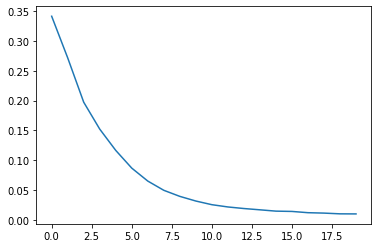

CPU times: user 16min 37s, sys: 6min 20s, total: 22min 58s
Wall time: 23min 19s


In [46]:
%%time
model = NNModel(embeddings).to(device)
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.BCEWithLogitsLoss()  # 内部でsigmoidを持つ

loss_train_list = []
loss_best = 100
EPOCHS = 20
PATIENCE = 3
for epoch in range(EPOCHS):
    loss_train = train_model(train_loader, model, criterion, optimizer)
    loss_train_list.append(loss_train)
    
    # lossが収束するまで続ける
    if loss_train < loss_best:
        loss_best = loss_train
        best_weight = deepcopy(model.state_dict())
        patience = 0
    else:
        patience += 1
        if patience > PATIENCE:
            break

plt.plot(range(len(loss_train_list)), loss_train_list)
plt.show()

In [53]:
model = NNModel(embeddings).to(device)
model.load_state_dict(best_weight)

model.eval()
with torch.no_grad():
    pred_list = []
    for X, y in tqdm(test_loader):
        pred = model(X)
        pred_list.extend(F.sigmoid(pred).detach().cpu().numpy())

y_pred = [1 if p>=0.5 else 0 for p in pred_list]
score = accuracy_score(y_test, y_pred)

print('')
print(f'acc(LSTM): {score:.3f}')

  0%|          | 0/358 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 358/358 [00:03<00:00, 96.79it/s]


acc(LSTM): 0.891
